# Mini-Kaggle Project 2: Adult Income Classification
Don Krapohl

## Summary

I used looping to try out many hyperparameters to choose the best model over the preprocessed data. 


## Requirements

Predict the income level of individuals based on various demographic and personal information.

- Split the provided dataset into a suitable training set and testing set.
- Train various classifiers on your training set, including Logistic Regression, SVM, Decision Trees, KNN, and Random Forest.
- Compare the performance of the classifiers and submit your best score.
- Aim to beat the benchmark performance of 78% on the hidden test dataset. If your performance is lower than 78%, you will lose the entire 70% of the grade allocated for the coding portion of this assignment.
- Note that the provided test dataset (`test.csv`) does not have target variables and is solely for testing your submission within our Kaggle system. Your training dataset (`train.csv`) is all you have, so split it appropriately for training and evaluation purposes.
- Submit your final notebook to Canvas for peer-review.
- In your notebook, use markdown to explain your steps, rationale, and exploration of the model's performance on various classifiers. Clearly mention which classifier you have decided on and your rationale to submit it as your final submission on Kaggle.
- Your Kaggle team name should be exactly identical to your name in Canvas.
- Your notebook submitted on Canvas will be peer-reviewed for further evaluation.
- Submit your submission file on Kaggle and notebook on Canvas by Nov 17, 2024, 11:59 PM.

### We will be training, testing, and using the following models:

* Logistic Regression
* SVM
* Decision Trees
* Random Forest
* KNN

Ref: https://scikit-learn.org/1.5/supervised_learning.html

## Approach

I will:
* load from train.csv
* explore the data for quality and distribution
* scale and encode the features
* do feature selection to reduce dimensionality
* split the data into train and test sets
* train all the models and select the one with the best accuracy
    
I'll train multiple models for each of the classifier algorithms and capture the one of each type that has the highest accuracy. After all are trained and tested I'll select the one with the highest accuracy and highest AUC as my submission.  I'll then predict over the test.csv file and submit the results.

## Environment Setup

### Establish environment
1. Download the python venv for the project from https://github.com/dkrapohl/uwf-venv-breast-cancer/tree/main (I'm using the same one from project 1)
2. Activate the environment using the README from that repo
3. Set the Jupyter environment to use this kernel (top right of this window)

If we need to reproduce the environment the private repo for this notebook has a pip requirements.txt

## Data Exploration

### Import required libraries.


In [1]:
# basic dataframe and operations
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# manipulation and preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# measuring results
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error, roc_auc_score, precision_score, recall_score

# warning suppression
import warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
# Suppress ConvergenceWarnings and UserWarning.  They're noise here.
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
''' Method: measure_model
    Purpose: output metrics about the selected model to allow model selection
    Parameters:
        best_model_params_info (string) - a string telling about the hyperparameters, solver, etc. as appropriate
        model_accuracy (double) - a numeric value having the accuracy of the passed model
        df_y_test (dataframe) - a dataframe holding the actual y values used to test
        dt_test_predictions (dataframe) - a dataframe containing the predicted y values to calculate scores
'''
def measure_model(best_model_params_info, model_accuracy, df_y_test, df_test_predictions):
    # Print the best model info
    print("Best model: {} , accuracy {}".format(best_model_params_info, "{:.4f}".format(model_accuracy)))
    print("MAE: {}, AUC: {}".format(mean_absolute_error(df_y_test, df_test_predictions), 
                                       roc_auc_score(df_y_test,df_test_predictions)))
    print("Precision: {}, Recall: {}".format(precision_score(df_y_test, df_test_predictions), 
                                       recall_score(df_y_test,df_test_predictions)))    
    # Print the confusion matrix for the best model
    print("Model Confusion Matrix:\n", confusion_matrix(df_y_test, df_test_predictions))
    print("Train data F1-Score for class '1':", f1_score(df_y_test, df_test_predictions, pos_label=1))
    print("Train data F1-Score for class '0':", f1_score(df_y_test, df_test_predictions, pos_label=0))
    


### Create a few collections to capture the info on our different models

To explore the accuracies of multiple model hyperparameters I'll be training multiple models and keeping the model from each type of classifier that has the highest accuracy.  I suspect there's an easier way to accomplish this but this is what I can do at this point.


In [4]:
# collections we'll use for our best of each type of model
best_models = []                    # List of model instances that are our best for final evaluation
model_accuracies = []               # The accuracies of our best models in a key-value dictionary

Here I'll load the data into an initial dataframe to be used for exploration and the start of preprocessing.


In [5]:
# Import the csv training dataset to a pandas dataframe
# The dataset is expected in the same directory as this notebook
#   under a subfolder path datasets/
data_train = pd.read_csv('datasets/train.csv')
# Show the shape of the dataset
data_train.shape


(39073, 16)

### Exploratory Data Analysis

Output the first 5 rows of the data to see the general character and nature of the data like missing values, obvious dirty data, features with very large ranges, etc.

In [6]:
# Display a few rows from the training data
data_train.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,id
0,78,Private,111189,7th-8th,4,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,35,Dominican-Republic,0,26052
1,49,Self-emp-inc,122066,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,25,United-States,0,47049
2,62,Self-emp-not-inc,168682,7th-8th,4,Married-civ-spouse,Sales,Husband,White,Male,0,0,5,United-States,0,33915
3,18,Private,110230,10th,6,Never-married,Other-service,Own-child,White,Male,0,0,11,United-States,0,22132
4,40,Private,373050,12th,8,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,?,0,46452


I notice that there are a lot of columns to encode. Also, education appears to be ordinal but there's a numeric version of it as well, which should cancel out as having low information value when I apply PCA and/or LDA. The id columns needs to be removed as well.

I also note that the "income" column is already discretized into two buckets with the bucket names already encoded as 0 and 1.  Per the documentation, column info:

    income: Target variable column indicating the income level ('<=50K': 0 or '>50K': 1).

### Look at the data to make sure we don't have null or missing data

This will give the count of null values for each column to see if we need to handle missing data.

In [7]:
# Get the count of nulls per column
# Turns out we don't have any
data_train.isnull().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
id                 0
dtype: int64

In [8]:
# Get the count of nulls per column
# Also, no nulls here
data_train.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
id                 0
dtype: int64

### I prefer to verify object data types. Not important here but at scale it definitely is.

Sometimes numeric data come in as object, which can make lookups and indexing inefficient.

In [9]:
# Verify data types to see if there's a better explicit cast for any feature or if we need to encode anything
data_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39073 entries, 0 to 39072
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              39073 non-null  int64 
 1   workclass        39073 non-null  object
 2   fnlwgt           39073 non-null  int64 
 3   education        39073 non-null  object
 4   educational-num  39073 non-null  int64 
 5   marital-status   39073 non-null  object
 6   occupation       39073 non-null  object
 7   relationship     39073 non-null  object
 8   race             39073 non-null  object
 9   gender           39073 non-null  object
 10  capital-gain     39073 non-null  int64 
 11  capital-loss     39073 non-null  int64 
 12  hours-per-week   39073 non-null  int64 
 13  native-country   39073 non-null  object
 14  income           39073 non-null  int64 
 15  id               39073 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 4.8+ MB



Need to encode (index):
> workclass - 1  
> education - 3  
> marital-status - 4  
> occupation - 6  
> relationship - 7  
> race - 8  
> gender - 9  
> native-country - 13  
    
The other features need to be scaled (index 0, 2, 4, 10, 11, 12, 14, 15)  

Income probably needs to be discretized (14)  

ID needs to be removed from training (15)  



### Get the statistics about the data and their distribution.

I'm looking here for any columns with differing counts and any outrageous outliers.

In [10]:
# Display basic metrics about each feature, like count, mean, std, min/max, and IQR
data_train.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income,id
count,39073.000000,3.907300e+04,39073.000000,39073.000000,39073.000000,39073.000000,39073.000000,39073.000000
mean,38.588207,1.900714e+05,10.072556,1067.195327,86.108796,40.390269,0.238144,24465.705372
std,13.695509,1.059839e+05,2.570352,7426.475044,399.342390,12.335446,0.425953,14072.213508
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,28.000000,1.175560e+05,9.000000,0.000000,0.000000,40.000000,0.000000,12319.000000
50%,37.000000,1.784780e+05,10.000000,0.000000,0.000000,40.000000,0.000000,24492.000000
75%,48.000000,2.383670e+05,12.000000,0.000000,0.000000,45.000000,0.000000,36610.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000,48842.000000


I see that some of the features, such as capital gain/loss have huge variability with the IQR being 0 but the max is 4356.

## Preprocessing

### Adjust columns as needed

1. Remove ID and make a dataframe of our target predictions. We need to remove income and ID from the training data. The former is the has no information and the latter is the value we're predicting.

In [11]:
# remove the result column from the input parameters
# also remove the ID column. It carries no signal.
X_train_without_label = data_train.drop('income', axis=1).drop('id', axis=1)

# Assign the variable we're targeting for the input data
y_values = data_train['income']      # assign the income continuous variable we'll discretize


2. Encode categorical values - I'll use the ColumnTransformer to encode multiple columns here

### Split and scale the data

Here I'll be splitting the data to be 70% training set, 30% test set. I then scale the data using the Standard Scaler to make all the data within the same range having 0 as the mean and standard deviation of 1.

In [12]:
# Do train test split
X_train, X_test, y_train, y_test =    train_test_split(X_train_without_label, y_values,
    test_size=0.3, 
    random_state=17)

### Encode and scale using a column transformer
I'll chain a OneHotEncoder and a StandardScaler to handle text encoding and numerical scaling respectively.

In [13]:
# Make a list of string categorical cols we need to encode
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
# Make a list of features we need to scale
numeric_features = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']

ohe = OneHotEncoder()           # creating a one hot encoder to do our column transforms
ss = StandardScaler()           # creating a scaler for transforming

feature_encoder = ColumnTransformer(
    transformers = [('onehot', ohe, categorical_features), 
                    ('scaler', ss, numeric_features)],
    remainder = 'passthrough'
)

X_train_std = feature_encoder.fit_transform(X_train)
X_test_std = feature_encoder.transform(X_test)


### PCA transformation
I'll apply PCA without specifying components then visualize what cut point I want to use for number of components.

In [14]:
# Here I'm not specifying the number of components.
# I want to chart and see how many to choose
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit(X_test_std)
print("PCA explained variance ratio: {}".format(pca.explained_variance_ratio_))


PCA explained variance ratio: [4.25611685e-01 8.97672343e-02 6.66385792e-02 6.15047898e-02
 5.84298528e-02 5.18611226e-02 3.71411350e-02 1.85466983e-02
 1.66020314e-02 1.51002102e-02 1.22314676e-02 1.07870150e-02
 1.02691788e-02 8.89636712e-03 7.99157719e-03 7.16889830e-03
 6.91759044e-03 6.61931254e-03 6.34897256e-03 6.29525517e-03
 5.48540861e-03 5.27347671e-03 4.89620003e-03 4.25983907e-03
 3.65399807e-03 3.52070689e-03 3.08678717e-03 2.92082939e-03
 2.81848390e-03 2.65748927e-03 2.53355163e-03 2.29719936e-03
 2.27088480e-03 2.11381289e-03 2.07090361e-03 2.00818789e-03
 1.90788560e-03 1.79950341e-03 1.75628599e-03 1.62885678e-03
 1.48266663e-03 1.19366562e-03 1.18158211e-03 1.04159034e-03
 9.74264309e-04 9.53707913e-04 9.05873371e-04 8.93135766e-04
 8.53076379e-04 7.29613731e-04 5.77094974e-04 5.48515488e-04
 3.63224094e-04 3.27798261e-04 2.95041577e-04 2.59540287e-04
 2.40091417e-04 2.31466649e-04 2.23321938e-04 2.18786499e-04
 1.95917049e-04 1.76086093e-04 1.66846675e-04 1.5104464

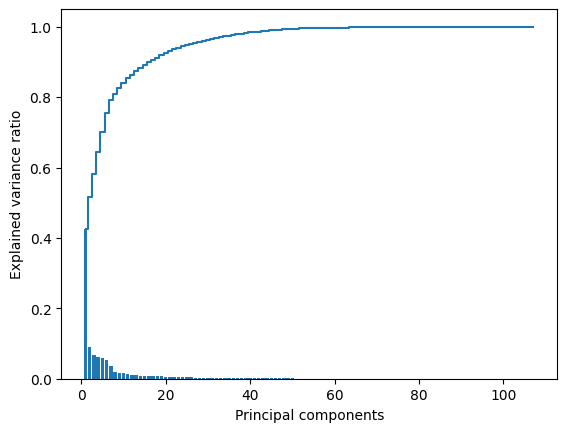

In [15]:
plt.bar(range(1, 108), pca.explained_variance_ratio_, align='center')
plt.step(range(1, 108), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

It appears that we can do a reasonable job of training with just 12 components so let's set that.  I'll compare this at the end of the notebook with our selected model on the original train/test set to see how much PCA improved it to know if I went wrong with my choice of components.

In [16]:
# Now I will select 12 principal components
pca = PCA(n_components=12)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

### Apply t-SNE for visualizing a dimensionally-reduce dataset
Code lifted with minor modification from this week's additional example pdf.

c:\github\uwf-venv-breast-cancer\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


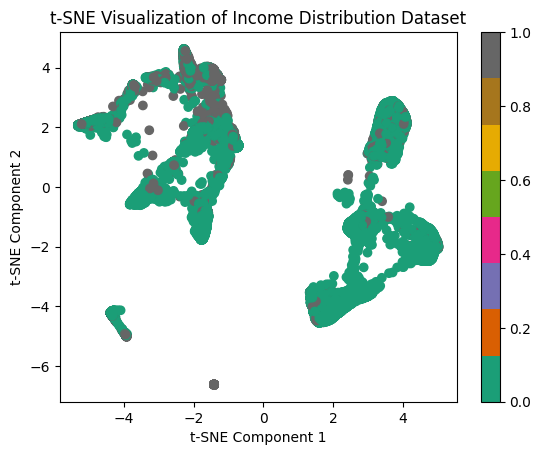

In [17]:
# Apply t-SNE to reduce the dimensionality of the data to 2 dimensions
tsne = TSNE(n_components=2, random_state=17, init='random',perplexity=50, n_iter=250)
X_tsne = tsne.fit_transform(X_train_pca)
# Plot the reduced data, color-coded by the class labels
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='Dark2')
plt.colorbar()
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Income Distribution Dataset')
plt.show()

This doesn't look at all separable but I'm super colorblind so trying it now in seaborn to see if it looks different

<Axes: xlabel='tsne-x', ylabel='tsne-y'>

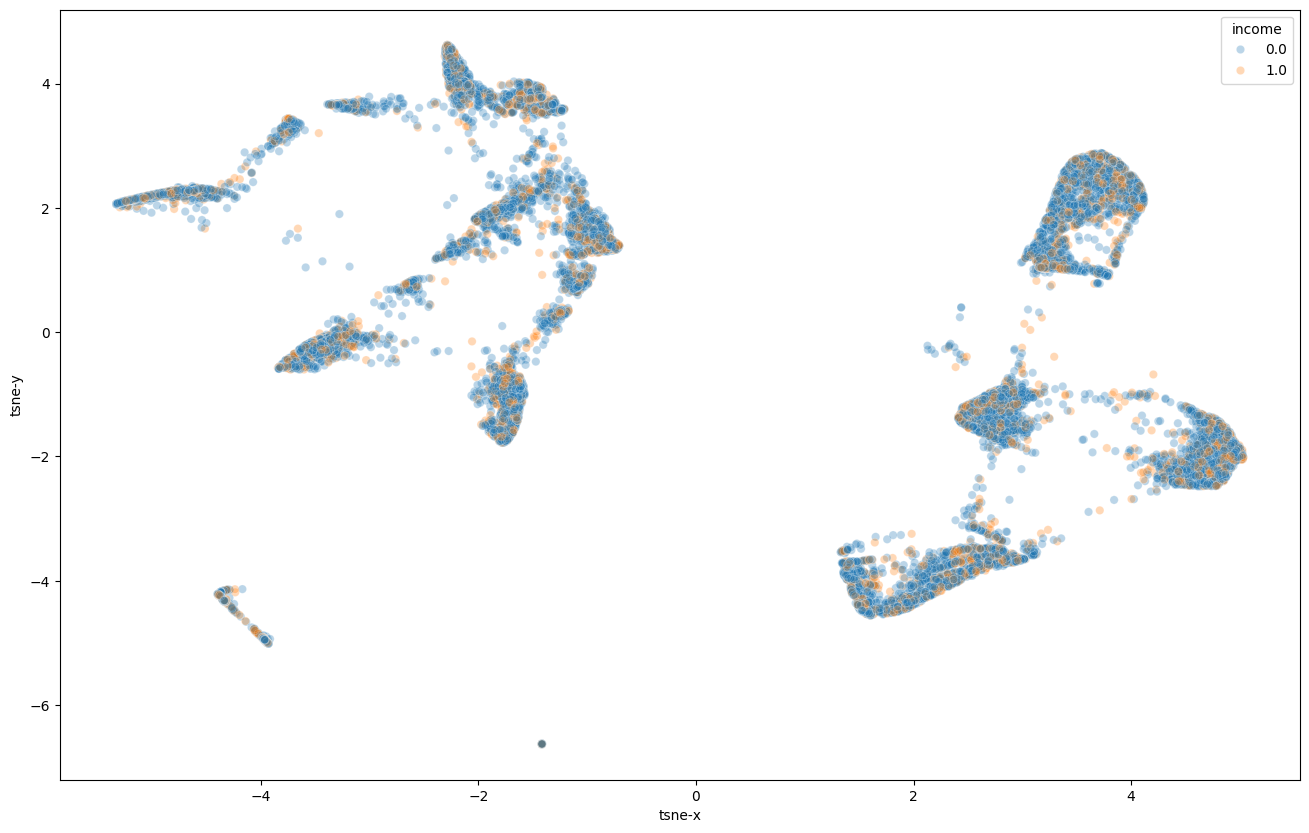

In [18]:
# Make a dataframe to do a seaborn scatterplot
tnse_sb_viz=pd.DataFrame()
tnse_sb_viz['tsne-x'] = X_tsne[:,0]
tnse_sb_viz['tsne-y'] = X_tsne[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-x", y="tsne-y",
    hue=y_train,
    palette=sns.color_palette("tab10", 2),
    data=tnse_sb_viz,
    legend="full",
    alpha=0.3
)

The data does not look at all separable to me. I anticipate the model I build will not do a great job at generalizing.

## Logistic Regression Train and Test

I'm looping through hyperparameters and training multiple models, keeping the "best" based on accuracy. The secondary consideration is that I will prefer the lowest C value as lower C values make simpler models.

This model assumes linearity in independent variables and performs well if the data are linearly separable. It'll also give use proababilities on the class predictions.

In [19]:
# In a loop over several values, train an SVM with different C values and capture the accuracies
# We prefer lower C for better power so we'll only update if accuracy is higher and C lower

solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
cs = [5.0, 3.0, 2.0, 1.0, 0.75, 0.5, 0.1, 0.01, 0.001, 0.0001]  # C values to try

# I'll also keep track of the highest accuracy for the lowest C as our "best" model
lr_highest_accuracy=0
lr_lowest_c=1000.0

# Try all SVM kernels
for solver in solvers:
    # Try the range of C values
    for c in cs:
        # Initialize and train the SVM model
        logreg_model = LogisticRegression(solver=solver, C=c, random_state = 17)
        logreg_model.fit(X_train_pca, y_train)

        # Make predictions using training data
        y_pred = logreg_model.predict(X_test_pca)
        model_test_score = accuracy_score(y_test, y_pred)
        model_auc = roc_auc_score(y_test, y_pred)
        model_f1 = f1_score(y_test, y_pred)

        # Print the accuracies for each of the model params so far.   
        print("Logistic Regression (solver={}\tscore={}\tauc={}\tf1={}".format(solver, "{:.4f}".format(model_test_score),
                                  "{:.4f}".format(model_auc), "{:.4f}".format(model_f1)))
            
        # we want the lowest C for better generalization so only keep
        #   accuracy if it's better but C is lower
        if model_test_score >= lr_highest_accuracy: # we're in a list with decreasing values so don't need to check C
            test_predictions = y_pred                   # store test predictions
            lr_lowest_c = c                             # store the lowest C
            lr_best_model = logreg_model                # store the best model
            lr_best_solver = solver                     # store the best solver
            lr_highest_accuracy = model_test_score       # update our highest score

best_models.append(lr_best_model)                       # add to our "best model" collection      
model_accuracies.append(lr_highest_accuracy)                # add the accuracy      

Logistic Regression (solver=lbfgs	score=0.8386	auc=0.7406	f1=0.6213
Logistic Regression (solver=lbfgs	score=0.8386	auc=0.7406	f1=0.6213
Logistic Regression (solver=lbfgs	score=0.8386	auc=0.7406	f1=0.6213
Logistic Regression (solver=lbfgs	score=0.8386	auc=0.7406	f1=0.6213
Logistic Regression (solver=lbfgs	score=0.8384	auc=0.7403	f1=0.6207
Logistic Regression (solver=lbfgs	score=0.8384	auc=0.7400	f1=0.6204
Logistic Regression (solver=lbfgs	score=0.8383	auc=0.7394	f1=0.6196
Logistic Regression (solver=lbfgs	score=0.8354	auc=0.7316	f1=0.6077
Logistic Regression (solver=lbfgs	score=0.8279	auc=0.7019	f1=0.5616
Logistic Regression (solver=lbfgs	score=0.8009	auc=0.5977	f1=0.3331
Logistic Regression (solver=liblinear	score=0.8385	auc=0.7406	f1=0.6212
Logistic Regression (solver=liblinear	score=0.8385	auc=0.7406	f1=0.6212
Logistic Regression (solver=liblinear	score=0.8385	auc=0.7406	f1=0.6212
Logistic Regression (solver=liblinear	score=0.8386	auc=0.7406	f1=0.6213
Logistic Regression (solver=libl

In [20]:
# Print the best model info
model_param_info ="{} solver, c {}".format(lr_best_solver, c, "{:.4f}")

measure_model(model_param_info, lr_highest_accuracy, y_test, test_predictions)


Best model: saga solver, c 0.0001 , accuracy 0.8386
MAE: 0.1614059034294489, AUC: 0.7406327699944444
Precision: 0.7096479195244627, Recall: 0.5525097899608401
Model Confusion Matrix:
 [[8278  635]
 [1257 1552]]
Train data F1-Score for class '1': 0.6212970376301041
Train data F1-Score for class '0': 0.897441457068517


## SVM Train and Test

As with Logistic Regression, looping to train multiple models, keeping the one with the highest accuracy for the lowest C value.  C value again we prefer lower C as it makes for simpler models.

This model will be computationally more expensive than the others, especially since I'm testing multiple C values on all kernels. The algorithm is more flexible in its ability to model both linear and non-linear data.

In [21]:
# In a loop over several values, train an SVM with different C values and capture the accuracies
# We prefer lower C for better power so we'll only update if accuracy is higher and C lower
cs = [5.0, 3.0, 2.0, 1.0, 0.75, 0.5, 0.1, 0.01, 0.001, 0.0001]  # C values to try
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# I'll also keep track of the highest accuracy for the highest eta as our "best" model
svm_highest_accuracy=0
svm_lowest_c=1000

# Try all SVM kernels
for kernel in kernels:
    # Loop through C values largest to smallest, train and test each
    for c in cs:
        # Initialize and train the SVM model
        linear_svm = SVC(kernel=kernel, C=c, random_state=17)
        linear_svm.fit(X_train_pca, y_train)

        # Make predictions using training data
        y_pred = linear_svm.predict(X_test_pca)
        model_test_score = accuracy_score(y_test, y_pred)
        model_auc = roc_auc_score(y_test, y_pred)
        model_f1 = f1_score(y_test, y_pred)

        # Print the accuracies for each of the model params so far.   
        print("SVM kernel={}, C={}, score={}, auc={}, f1={}".format(kernel, c, "{:.4f}".format(model_test_score),
                                  "{:.4f}".format(model_auc), "{:.4f}".format(model_f1)))
            
        # we want the lowest C for better generalization so only keep
        #   accuracy if it's better but C is lower
        if model_test_score >= svm_highest_accuracy: # we're in a list with decreasing values so don't need to check C
            svm_lowest_c = c                            # store lowest C
            test_predictions = y_pred                   # store test predictions
            svm_best_model = linear_svm                 # store the best model
            svm_best_kernel = kernel                    # store the best kernel
            svm_highest_accuracy = model_test_score     # update our highest score

best_models.append(svm_best_model)                      # add to our "best model" collection   
model_accuracies.append(svm_highest_accuracy)           # add the accuracy

SVM kernel=linear, C=5.0, score=0.8416, auc=0.7438, f1=0.6272
SVM kernel=linear, C=3.0, score=0.8416, auc=0.7438, f1=0.6272
SVM kernel=linear, C=2.0, score=0.8416, auc=0.7438, f1=0.6272
SVM kernel=linear, C=1.0, score=0.8416, auc=0.7438, f1=0.6272
SVM kernel=linear, C=0.75, score=0.8416, auc=0.7438, f1=0.6272
SVM kernel=linear, C=0.5, score=0.8416, auc=0.7438, f1=0.6272
SVM kernel=linear, C=0.1, score=0.8419, auc=0.7438, f1=0.6274
SVM kernel=linear, C=0.01, score=0.8406, auc=0.7389, f1=0.6204
SVM kernel=linear, C=0.001, score=0.8326, auc=0.7093, f1=0.5750
SVM kernel=linear, C=0.0001, score=0.7725, auc=0.5259, f1=0.0993
SVM kernel=rbf, C=5.0, score=0.8497, auc=0.7473, f1=0.6371
SVM kernel=rbf, C=3.0, score=0.8486, auc=0.7455, f1=0.6341
SVM kernel=rbf, C=2.0, score=0.8484, auc=0.7457, f1=0.6343
SVM kernel=rbf, C=1.0, score=0.8479, auc=0.7442, f1=0.6320
SVM kernel=rbf, C=0.75, score=0.8480, auc=0.7440, f1=0.6318
SVM kernel=rbf, C=0.5, score=0.8475, auc=0.7431, f1=0.6303
SVM kernel=rbf, C=

In [22]:
# Print the best model info
model_param_info ="{} kernel, C {}".format(svm_best_kernel, svm_lowest_c, "{:.4f}")
measure_model(model_param_info, svm_highest_accuracy, y_test, test_predictions)

Best model: rbf kernel, C 5.0 , accuracy 0.8497
MAE: 0.15031564579423307, AUC: 0.7473159812286141
Precision: 0.7557401074743527, Recall: 0.5507297970808117
Model Confusion Matrix:
 [[8413  500]
 [1262 1547]]
Train data F1-Score for class '1': 0.6371499176276771
Train data F1-Score for class '0': 0.9052076608564665


## Decision Trees Train and Test

With Decision Trees we're testing different splitting algorithms as well as model depth keeping the one with the highest accuracy and the lowest depth.  Lowest depth is selected as it makes for the simpler model.

This algorithm should be the easiest to interpret and captures non-linear relationships but it's prone to overfitting.  It's also at risk of creating biased trees if the classes are imbalanced but the classes here are relatively equally represented.

In [23]:
# In a loop over several values, train a decision tree with different split criteria and depths and capture the accuracies
# We prefer lower C for better power so we'll only update if accuracy is higher and depth lower
criteria = ['gini', 'entropy', 'log_loss']

# I'll also keep track of the highest accuracy for the lowest depth as our "best" model
dtree_highest_accuracy=0
dtree_lowest_depth=1000
dtree_best_criterion=''

# Try all SVM kernels
for criterion in criteria:
    # Loop through depth values smallest to largest, train and test each
    for depth in range(25, 1, -1):   # Allow up to depth 5 starting at 5 and down to 1
        # Initialize and train the decision tree model
        decision_tree = DecisionTreeClassifier(criterion=criterion, max_depth=depth, random_state=17)
        decision_tree.fit(X_train_pca, y_train)
    
        # Make predictions using training data
        y_pred = decision_tree.predict(X_test_pca)
        model_test_score = accuracy_score(y_test, y_pred)
        model_auc = roc_auc_score(y_test, y_pred)
        model_f1 = f1_score(y_test, y_pred)        

        # Print the accuracies for each of the model params so far.   
        print("Decision Tree (criterion={}, depth={}, score={}, auc={}, f1={})".format(criterion, depth, "{:.4f}".format(model_test_score),
                                  "{:.4f}".format(model_auc), "{:.4f}".format(model_f1)))
            
        # we want the lowest C for better generalization so only keep
        #   accuracy if it's better but C is lower
        if model_test_score >= dtree_highest_accuracy:
            dtree_lowest_depth = depth              # store lowest depth
            test_predictions = y_pred               # store test predictions
            dtree_best_model = decision_tree        # store the best model
            dtree_best_criterion = criterion        # store the best kernel
            dtree_highest_accuracy = model_test_score   # update our highest score

best_models.append(dtree_best_model)                # add to our "best model" collection
model_accuracies.append(dtree_highest_accuracy)     # add the accuracy

Decision Tree (criterion=gini, depth=25, score=0.7916, auc=0.7169, f1=0.5688)
Decision Tree (criterion=gini, depth=24, score=0.7953, auc=0.7206, f1=0.5747)
Decision Tree (criterion=gini, depth=23, score=0.7912, auc=0.7176, f1=0.5695)
Decision Tree (criterion=gini, depth=22, score=0.7895, auc=0.7134, f1=0.5636)
Decision Tree (criterion=gini, depth=21, score=0.7936, auc=0.7154, f1=0.5675)
Decision Tree (criterion=gini, depth=20, score=0.7957, auc=0.7185, f1=0.5722)
Decision Tree (criterion=gini, depth=19, score=0.7955, auc=0.7200, f1=0.5740)
Decision Tree (criterion=gini, depth=18, score=0.7954, auc=0.7171, f1=0.5704)
Decision Tree (criterion=gini, depth=17, score=0.7983, auc=0.7221, f1=0.5777)
Decision Tree (criterion=gini, depth=16, score=0.8000, auc=0.7222, f1=0.5786)
Decision Tree (criterion=gini, depth=15, score=0.8037, auc=0.7263, f1=0.5852)
Decision Tree (criterion=gini, depth=14, score=0.8121, auc=0.7295, f1=0.5928)
Decision Tree (criterion=gini, depth=13, score=0.8135, auc=0.735

In [24]:
# Print the best model info
model_param_info ="{} criterion, depth {}".format(dtree_best_criterion, dtree_lowest_depth)
measure_model(model_param_info, dtree_highest_accuracy, y_test, test_predictions)

Best model: log_loss criterion, depth 7 , accuracy 0.8369
MAE: 0.1631120969117898, AUC: 0.7325624304593548
Precision: 0.7142857142857143, Recall: 0.5322178711285155
Model Confusion Matrix:
 [[8315  598]
 [1314 1495]]
Train data F1-Score for class '1': 0.6099551203590371
Train data F1-Score for class '0': 0.8968827526696149


## Random Forest Train and Test

This is very much like Decision Trees except we're tuning splitting criteria as well as the number of estimators used.  We'll prefer fewer estimators for simpler models.

The Random Forest algorithm is harder to interpret because it's an ensemble of decision trees but it's less likely to overfit. It can be harder to compute than a single or a few decision trees.

In [25]:
# In a loop over several values, train a random forest with different split criteria and estimator count and capture the accuracies
criteria = ['gini', 'entropy', 'log_loss']

# I'll also keep track of the highest accuracy for the lowest number of estimators as our "best" model
rforest_highest_accuracy=0
rforest_lowest_estimators=1000
rforest_best_criterion=''

# Try all random forest split criteria
for criterion in criteria:
    # Loop through depth values smallest to largest, train and test each
    for estimators in range(500, 50, -50):   # Allow up to 500 estimators decreasing by 50 each loop
        # Initialize and train the decision tree model
        random_forest = RandomForestClassifier(criterion=criterion, n_estimators=estimators, random_state=17, n_jobs=-1)
        random_forest.fit(X_train_pca, y_train)

        # Make predictions using training data
        y_pred = random_forest.predict(X_test_pca)
        model_test_score = accuracy_score(y_test, y_pred)
        model_auc = roc_auc_score(y_test, y_pred)
        model_f1 = f1_score(y_test, y_pred)

        # Print the accuracies for each of the model params so far.   
        print("Random Forest Test (criterion={}, estimators={}, score={}, auc={}, f1={})".format(criterion, estimators, 
              "{:.4f}".format(model_test_score), "{:.4f}".format(model_auc), "{:.4f}".format(model_f1)))
            
        # we want the lowest number of estimators for better generalization 
        if model_test_score >= rforest_highest_accuracy:
            rforest_lowest_estimators = estimators  # store lowest number of estimators
            test_predictions = y_pred               # store test predictions
            rforest_best_model = random_forest      # store the best model
            rforest_best_criterion = criterion      # store the best criterion
            rforest_highest_accuracy = model_test_score # update our highest score
            
best_models.append(rforest_best_model)              # add to our "best model" collection        
model_accuracies.append(rforest_highest_accuracy)   # add the accuracy    


Random Forest Test (criterion=gini, estimators=500, score=0.8446, auc=0.7577, f1=0.6457)
Random Forest Test (criterion=gini, estimators=450, score=0.8449, auc=0.7581, f1=0.6463)
Random Forest Test (criterion=gini, estimators=400, score=0.8452, auc=0.7578, f1=0.6461)
Random Forest Test (criterion=gini, estimators=350, score=0.8451, auc=0.7581, f1=0.6464)
Random Forest Test (criterion=gini, estimators=300, score=0.8453, auc=0.7588, f1=0.6475)
Random Forest Test (criterion=gini, estimators=250, score=0.8451, auc=0.7579, f1=0.6463)
Random Forest Test (criterion=gini, estimators=200, score=0.8441, auc=0.7572, f1=0.6448)
Random Forest Test (criterion=gini, estimators=150, score=0.8435, auc=0.7557, f1=0.6426)
Random Forest Test (criterion=gini, estimators=100, score=0.8423, auc=0.7530, f1=0.6387)
Random Forest Test (criterion=entropy, estimators=500, score=0.8441, auc=0.7563, f1=0.6437)
Random Forest Test (criterion=entropy, estimators=450, score=0.8436, auc=0.7565, f1=0.6436)
Random Forest T

In [26]:
# Print the best model info
model_param_info ="{} criterion, estimators {}".format(rforest_best_criterion, rforest_lowest_estimators)
measure_model(model_param_info, rforest_highest_accuracy, y_test, test_predictions)

Best model: gini criterion, estimators 300 , accuracy 0.8453
MAE: 0.15466643917420236, AUC: 0.7588393631615644
Precision: 0.7133676092544987, Recall: 0.5927376290494838
Model Confusion Matrix:
 [[8244  669]
 [1144 1665]]
Train data F1-Score for class '1': 0.6474820143884892
Train data F1-Score for class '0': 0.9009343751707557


## KNN Train and Test

This is simpler as I'm only tuning the number of neighbors and keeping the one with the highest accuracy. We'll prefer the model with the fewest neighbors.

KNN, while computational a bit expensive is simple for this problem and doesn't appear to require much tuning.

In [27]:
# In a loop over several values, train a knn movel with different number of neighbors

# I'll also keep track of the highest accuracy for the lowest # nieghbors as our "best" model
knn_highest_accuracy=0
knn_lowest_neighbors=1

# Loop through neighbor values, train and test each
for n_neighbors in range(2, 25):   # Allow up to 50 neighbors increasing by 1 each loop
    # Initialize and train the decision tree model
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train_pca, y_train)

    # Make predictions using training data
    y_pred = knn_model.predict(X_test_pca)
    model_test_score = accuracy_score(y_test, y_pred)
    model_auc = roc_auc_score(y_test, y_pred)
    model_f1 = f1_score(y_test, y_pred)

    # Print the accuracies for each of the model params so far.   
    print("KNN Test (neighbors={}, score={}, auc={}, f1={}".format(n_neighbors, "{:.4f}".format(model_test_score),
                                  "{:.4f}".format(model_auc), "{:.4f}".format(model_f1)))
        
    # we want the lowest number of estimators for better generalization 
    if model_test_score >= knn_highest_accuracy:
        knn_lowest_neighbors = n_neighbors      # store lowest number of estimators
        test_predictions = y_pred               # store test predictions
        knn_best_model = knn_model              # store the best model
        knn_highest_accuracy = model_test_score # update our highest score

best_models.append(knn_best_model)              # add to our "best model" collection  
model_accuracies.append(knn_highest_accuracy)   # add the accuracy    

KNN Test (neighbors=2, score=0.8179, auc=0.6799, f1=0.5221
KNN Test (neighbors=3, score=0.8234, auc=0.7422, f1=0.6141
KNN Test (neighbors=4, score=0.8280, auc=0.7087, f1=0.5720
KNN Test (neighbors=5, score=0.8314, auc=0.7490, f1=0.6267
KNN Test (neighbors=6, score=0.8296, auc=0.7159, f1=0.5832
KNN Test (neighbors=7, score=0.8343, auc=0.7487, f1=0.6283
KNN Test (neighbors=8, score=0.8357, auc=0.7260, f1=0.6006
KNN Test (neighbors=9, score=0.8359, auc=0.7472, f1=0.6276
KNN Test (neighbors=10, score=0.8375, auc=0.7306, f1=0.6078
KNN Test (neighbors=11, score=0.8385, auc=0.7486, f1=0.6309
KNN Test (neighbors=12, score=0.8396, auc=0.7325, f1=0.6116
KNN Test (neighbors=13, score=0.8405, auc=0.7481, f1=0.6316
KNN Test (neighbors=14, score=0.8412, auc=0.7355, f1=0.6165
KNN Test (neighbors=15, score=0.8406, auc=0.7498, f1=0.6337
KNN Test (neighbors=16, score=0.8396, auc=0.7355, f1=0.6154
KNN Test (neighbors=17, score=0.8399, auc=0.7479, f1=0.6310
KNN Test (neighbors=18, score=0.8397, auc=0.7354

In [28]:
# Print the best model info
model_param_info ="{} neighbors".format(knn_lowest_neighbors)
measure_model(model_param_info, knn_highest_accuracy, y_test, test_predictions)


Best model: 14 neighbors , accuracy 0.8412
MAE: 0.1587613035318205, AUC: 0.7355453214785367
Precision: 0.7318982387475538, Recall: 0.5325738697045211
Model Confusion Matrix:
 [[8365  548]
 [1313 1496]]
Train data F1-Score for class '1': 0.6165258602926025
Train data F1-Score for class '0': 0.8998978000107579


## Final Model Selection

Here I enumerate through the best model for each type of classifier; do cross validation; and output AUC, accuracy, and info on the hyperparameters of our best of each type of model.  I'll use this to select the best model.

The best model I will choose is the one with the highest AUC that has the lowest standard deviation and the one with the highest accuracy.

After this I will load the test.csv we need to predict over, do predictions, encode the class label outputs of the predictions, and save the final csv.

In [29]:
# Do some cross validation on all models using AUC
for model, accuracy in zip(best_models, model_accuracies):
        score = cross_val_score(estimator=model,
                                X=X_train_pca,
                                y=y_train,
                                cv=10,
                                scoring='roc_auc')
        print(f'ROC AUC: {score.mean():.2f} '
                f'(+/- {score.std():.2f}) [Accuracy {accuracy:.4f}]', model)

ROC AUC: 0.89 (+/- 0.01) [Accuracy 0.8386] LogisticRegression(random_state=17, solver='saga')
ROC AUC: 0.88 (+/- 0.01) [Accuracy 0.8497] SVC(C=5.0, random_state=17)
ROC AUC: 0.88 (+/- 0.01) [Accuracy 0.8369] DecisionTreeClassifier(criterion='log_loss', max_depth=7, random_state=17)
ROC AUC: 0.90 (+/- 0.01) [Accuracy 0.8453] RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=17)
ROC AUC: 0.88 (+/- 0.01) [Accuracy 0.8412] KNeighborsClassifier(n_neighbors=14)


In [30]:
# We'll choose our RF model but let's try it without PCA with 300 estimators and gini criterion
random_forest_no_pca = RandomForestClassifier(criterion='gini', n_estimators=300, random_state=17)
random_forest_no_pca.fit(X_train_std, y_train)  

# Make predictions using training data
test_predictions = random_forest_no_pca.predict(X_test_std)
# Output model basic metrics
model_test_score = accuracy_score(y_test, y_pred)
model_param_info="Random Forest with PCA, gini criterion, 300 estimators"
measure_model(model_param_info, model_test_score, y_test, test_predictions)

print("Score: {}".format(model_test_score))
score = cross_val_score(estimator=random_forest_no_pca,
                        X=X_train_pca,
                        y=y_train,
                        cv=10,
                        scoring='roc_auc')
print(f'ROC AUC: {score.mean():.2f} ' f'(+/- {score.std():.2f})')
    

Best model: Random Forest with PCA, gini criterion, 300 estimators , accuracy 0.8399
MAE: 0.14323494284251834, AUC: 0.7786685197924305
Precision: 0.7352206494587843, Recall: 0.6286934852260591
Model Confusion Matrix:
 [[8277  636]
 [1043 1766]]
Train data F1-Score for class '1': 0.6777969679524084
Train data F1-Score for class '0': 0.9079142214665716
Score: 0.8398737416823068
ROC AUC: 0.90 (+/- 0.01)


The model without PCA has no accuracy improvement but takes much longer to train and is much more complex.  I will select the dimensionally-reduced model (PCA applied version) of the model.

#### Try LDA on this Random Forest model

I'm certain that training models with LDA would yield different accuracies for each set of hyperparameters than PCA did, but I'll try our chosen model only with LDA.

In [31]:
# Fit a linear descriminant to see if it's better than PCA on the Random Forest model we chose. 
lda = LDA(n_components=1)                                           # 2 classes of income so n-1 components
X_train_lda = lda.fit_transform(X_train_std.toarray(), y_train)
X_test_lda = lda.transform(X_test_std.toarray())

# I'll try the same thing but I did with PCA but with LDA
# We'll choose our RF model and let's try it with 300 estimators and gini criterion
random_forest_lda = RandomForestClassifier(criterion='gini', n_estimators=300, random_state=17)
random_forest_lda.fit(X_train_lda, y_train)

RandomForestClassifier(n_estimators=300, random_state=17)

In [32]:
# Print the metrics on the training set
# Make predictions using test data
test_predictions = random_forest_lda.predict(X_test_lda)

# Output model basic metrics
model_test_score = accuracy_score(y_test, y_pred)
model_param_info="Random Forest with LDA, gini criterion, 300 estimators"
measure_model(model_param_info, model_test_score, y_test, test_predictions)

score = cross_val_score(estimator=random_forest_lda,
                        X=X_train_pca,
                        y=y_train,
                        cv=10,
                        scoring='roc_auc')
print(f'ROC AUC: {score.mean():.2f} ' f'(+/- {score.std():.2f})')

Best model: Random Forest with LDA, gini criterion, 300 estimators , accuracy 0.8399
MAE: 0.21796621736904964, AUC: 0.7031961027322502
Precision: 0.5446240337315531, Recall: 0.5517977928088288
Model Confusion Matrix:
 [[7617 1296]
 [1259 1550]]
Train data F1-Score for class '1': 0.5481874447391689
Train data F1-Score for class '0': 0.856371915228512
ROC AUC: 0.90 (+/- 0.01)


The LDA dimensionality reduction did not improve the model, but made it worse.

## A last check of the selected model metrics
Look at the train and test metrics to make sure we're not over- or underfitting

In [33]:
y_pred = rforest_best_model.predict(X_train_pca)
model_test_score = accuracy_score(y_train, y_pred)
print("Training score: {}".format(model_test_score))

y_pred = rforest_best_model.predict(X_test_pca)
model_test_score = accuracy_score(y_test, y_pred)
print("Testing score: {}".format(model_test_score))

y_pred = svm_best_model.predict(X_train_pca)
model_test_score = accuracy_score(y_train, y_pred)
print("Training score: {}".format(model_test_score))

y_pred = svm_best_model.predict(X_test_pca)
model_test_score = accuracy_score(y_test, y_pred)
print("Testing score: {}".format(model_test_score))

Training score: 0.9999268765310226
Testing score: 0.8453335608257977
Training score: 0.8563855069284487
Testing score: 0.8496843542057669


It's apparent my random forest model (the first set of train/test scores here) is overfitting.  Comparing it to the SVM, the SVM test score is much closer to the train score, both of which are marginally better than my random forest model.

I will now change my decision and submit my SVM model instead.

## Predict over our model and save the result

I'll now read in the test.csv, clean and transform it, apply the previously fit PCA matrix, predict the outputs, and save them for submission.

In [35]:
# Do predictions on the submission test set and save the output as csv
data_test_input = pd.read_csv('datasets/test.csv') # get the test inputs

# remove the ID column and the save it in output_ids
output_ids = data_test_input['id']                  # set the IDs we'll output but don't predict on them
X_test_cleansed = data_test_input.drop('id', axis=1)

# Need to encode the test data
# This uses the OHE and scaler we trained earlier as feature_encoder
X_test_std = feature_encoder.transform(X_test_cleansed)

# Use the previous pca matrix to transform the test data
X_test_pca = pca.transform(X_test_std)

# Now ready for predicting. Predict and store results.
y_pred = svm_best_model.predict(X_test_pca)   # use the model to predict outcomes

output_df = pd.DataFrame(output_ids)                # prep a dataframe for our output
output_df = output_df.assign(label=y_pred)  # append the predictions to the IDs

output_df.to_csv("DonKrapohl_project2_submission.csv", index=False) # write the csv

print(output_df)

print('csv written.')                               # complete

         id  label
0       392      0
1      1900      0
2     24507      0
3     32817      1
4     47893      0
...     ...    ...
9764  13000      0
9765  43012      0
9766  34782      0
9767  23538      0
9768  23097      0

[9769 rows x 2 columns]
csv written.


## Conclusion

My choice of models ultimately used the SVM classifier with PCA reducing our set to 12 principal components, which achieved an accuracy 0.8497 on my local machine. Submitted to Kaggle it achieved 0.85433 accuracy.
